In [7]:
import pywt
import numpy as np
import datetime
from segmentation_3D import *
from skimage.external import tifffile
import matplotlib.pyplot as plt
import os

out_path = '/hybedata/Images/Zach/ExVivo/Predigest_WholeMount_Second_2019Feb17/results/Attempt1/'
def load_tiff(full_fname):
    dout = tifffile.imread(full_fname).astype(np.float64)
    dout = np.swapaxes(np.swapaxes(dout,0,2),0,1)
    return dout

In [ ]:
from metadata import Metadata
import matplotlib.pyplot as plt
out_path = '/hybedata/Images/Zach/ExVivo/Predigest_WholeMount_First_2019Jan19/results/Attempt4/'
if not os.path.exists(out_path):
    os.makedirs(out_path)
img_path = '/hybedata/Images/Zach/ExVivo/Predigest_WholeMount_Second_2019Feb17/'
md = Metadata(img_path)
pos = 'Pos235'

In [13]:
params = {
        'image_blur' : 4.0, #gaussian kernal
        'threshold' : 65, #0-100
        'smallest_object' : 900, #pixels
        'dist_intensity_ratio' : 0.75, #0-1 weight
        'separation_distance' : 50, #pixels
        'edge_filter_blur' : 1.0, #kernel width in pixels
        'watershed_ratio' : 0.9, #0-1 ratio of distance from edge vs bwgeodesic
        'remove_image_edges': 0, # If true set all edges to 0
        'wavelet': 'db9', # wavelet to use
        'keep_list': [4,5,6], # wavelets to keep
                 }

In [41]:
nucstk = np.swapaxes(np.swapaxes(tifffile.imread(os.path.join(out_path,'Raw_Pos6.tiff')).astype(np.float64),0,2),0,1)
wave_edge = np.swapaxes(tifffile.imread(os.path.join(out_path,'wave_edge_Pos6.tiff')).astype(np.float64),0,2)
wave_cell = np.swapaxes(tifffile.imread(os.path.join(out_path,'wave_cell_Pos6.tiff')).astype(np.float64),0,2)
wave_sum = np.swapaxes(tifffile.imread(os.path.join(out_path,'wave_sum_Pos6.tiff')).astype(np.float64),0,2)
blurred = np.swapaxes(tifffile.imread(os.path.join(out_path,'Blur_Pos6.tiff')).astype(np.float64),0,2)
cell_center = np.swapaxes(tifffile.imread(os.path.join(out_path,'cell_centers_Pos6.tiff')).astype(np.float64),0,2)
markers = np.swapaxes(tifffile.imread(os.path.join(out_path,'markers_Pos6.tiff')),0,2)
im_edge = np.swapaxes(tifffile.imread(os.path.join(out_path,'im_edge_Pos6.tiff')).astype(np.float64),0,2)
labels = np.swapaxes(tifffile.imread(os.path.join(out_path,'watershed_Pos6.tiff')),0,2)


In [30]:
z = 65

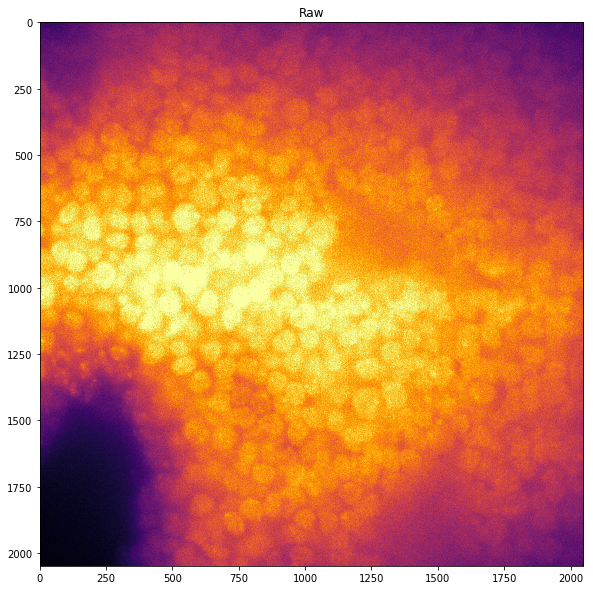

In [31]:
nucstk = md.stkread(Position=pos,Channel='DeepBlue',acq='nuc_extended_11')
fname = os.path.join(out_path,'Raw_Pos235.tiff')
tifffile.imsave(fname, np.swapaxes(np.swapaxes(nucstk,0,2),1,2), metadata={'axes': 'ZYX'})
Display(nucstk[:,:,z],title='Raw')

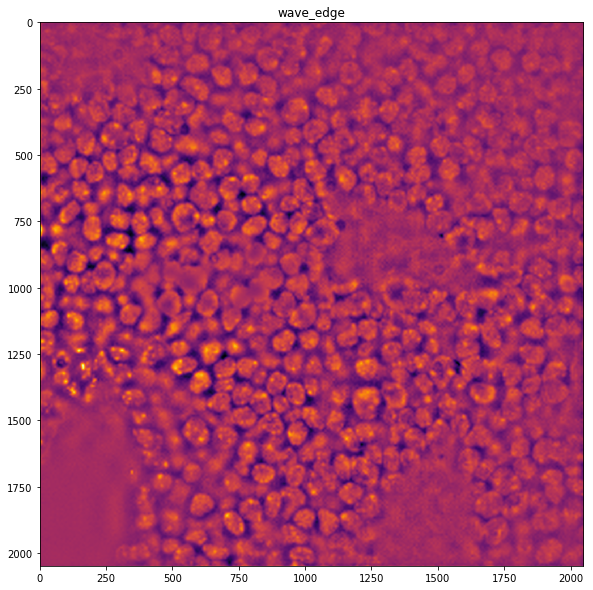

In [32]:
wave_edge = wavelettransform(nucstk,'db9',keep_list=[4,5,6])
fname = os.path.join(out_path,'wave_edge_Pos235.tiff')
tifffile.imsave(fname, np.swapaxes(wave_edge,0,2), metadata={'axes': 'ZYX'})
Display(wave_edge[:,:,z],title='wave_edge')

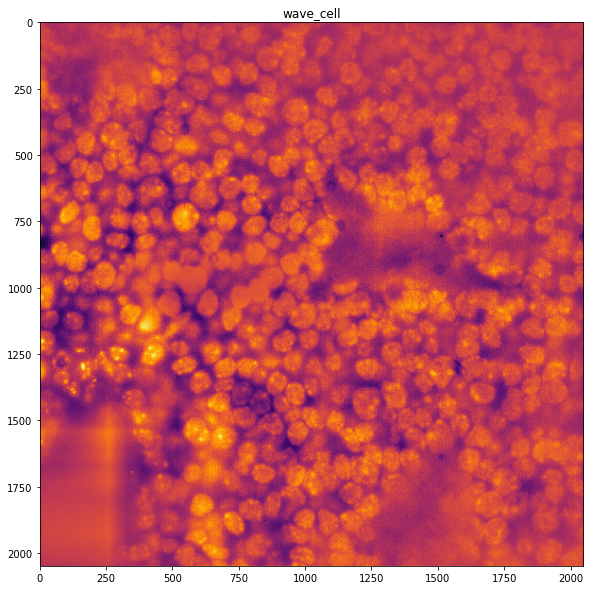

In [33]:
wave_cell = wavelettransform(nucstk,'db3',keep_list=[3,4,5,6,7,8])
fname = os.path.join(out_path,'wave_cell_Pos235.tiff')
tifffile.imsave(fname, np.swapaxes(wave_cell,0,2), metadata={'axes': 'ZYX'})
Display(wave_cell[:,:,z],title='wave_cell')

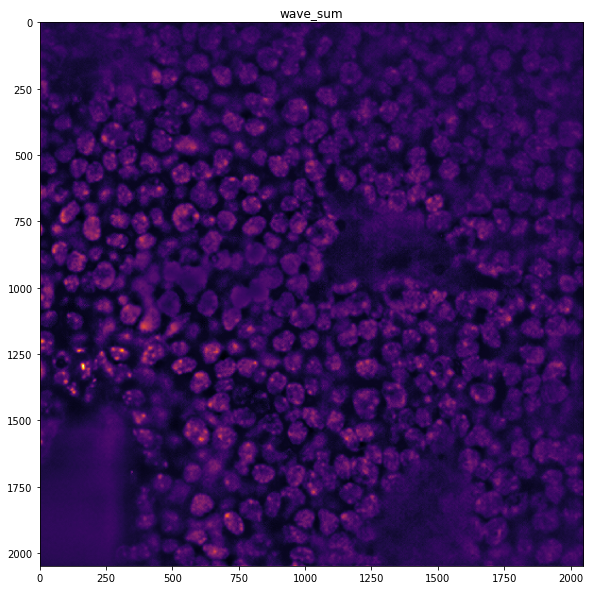

In [34]:
wave_sum = wave_edge * wave_cell
fname = os.path.join(out_path,'wave_sum_Pos235.tiff')
tifffile.imsave(fname, np.swapaxes(wave_sum,0,2), metadata={'axes': 'ZYX'})
Display(wave_sum[:,:,z],title='wave_sum')

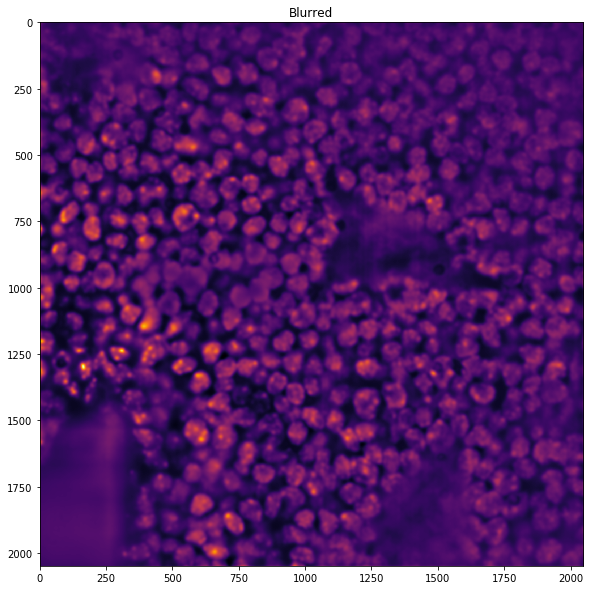

In [35]:
blurred = blur(wave_sum, params['image_blur'])
fname = os.path.join(out_path,'Blur_Pos235.tiff')
tifffile.imsave(fname, np.swapaxes(blurred,0,2), metadata={'axes': 'ZYX'})
Display(blurred[:,:,z],title='Blurred')

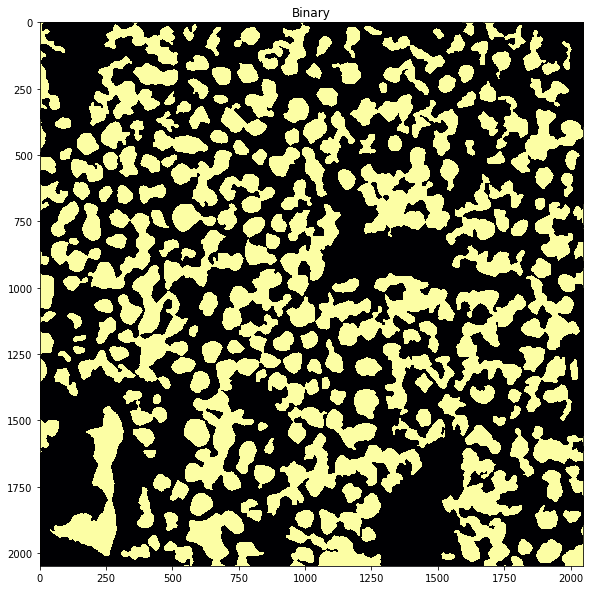

In [36]:
im_bin = binarize(blurred,params['threshold'],params['smallest_object'])
Display(im_bin[:,:,z],title='Binary')

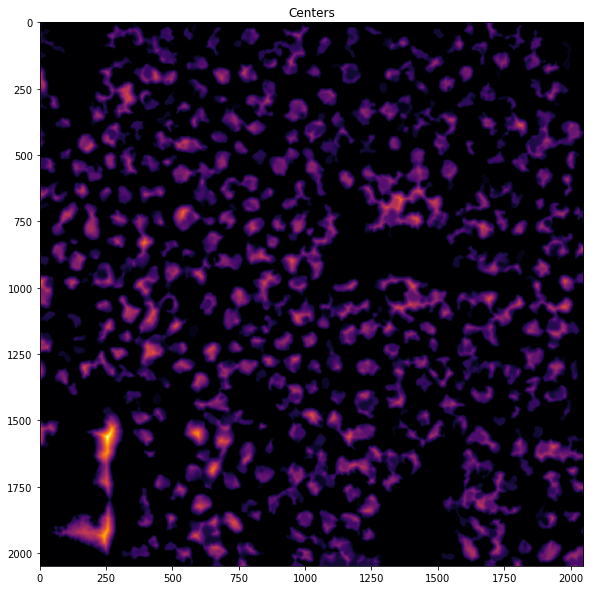

In [37]:
[cell_center, d_mat] = cell_centers(blurred, im_bin, params['dist_intensity_ratio'])
fname = os.path.join(out_path,'cell_centers_Pos235.tiff')
tifffile.imsave(fname, np.swapaxes(cell_center,0,2), metadata={'axes': 'ZYX'})
Display(cell_center[:,:,z],title='Centers')

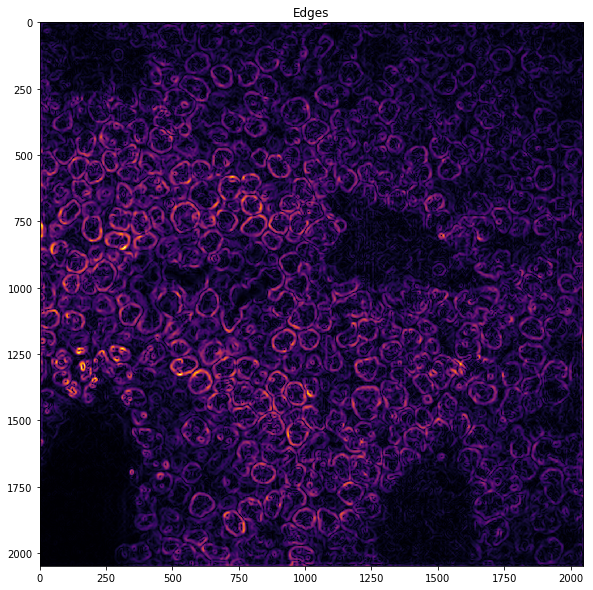

In [38]:
im_edge = sobel_edges(wave_edge, params['edge_filter_blur'])
fname = os.path.join(out_path,'im_edge_Pos235.tiff')
tifffile.imsave(fname, np.swapaxes(im_edge,0,2), metadata={'axes': 'ZYX'})
Display(im_edge[:,:,z],title='Edges')

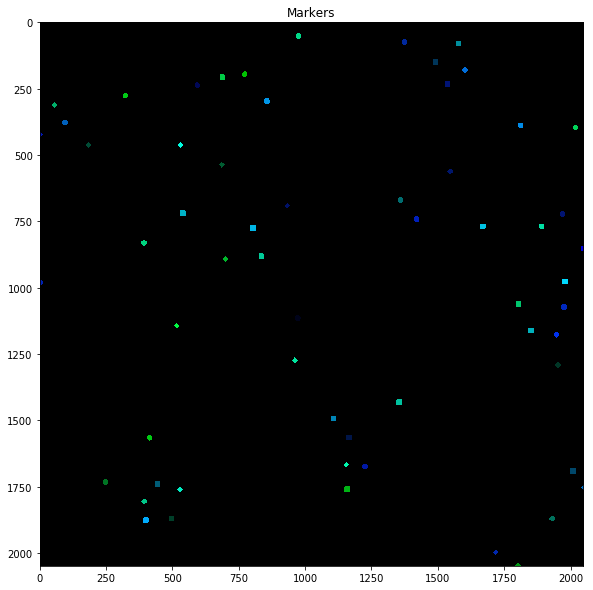

In [42]:
markers = fg_markers(cell_center, im_bin, params['separation_distance'], params['remove_image_edges'])
fname = os.path.join(out_path,'markers_Pos235.tiff')
tifffile.imsave(fname, np.swapaxes(markers,0,2), metadata={'axes': 'ZYX'})
out = colorize_segmented_image(markers[:,:,z], 'bg')
Display(out,title='Markers')

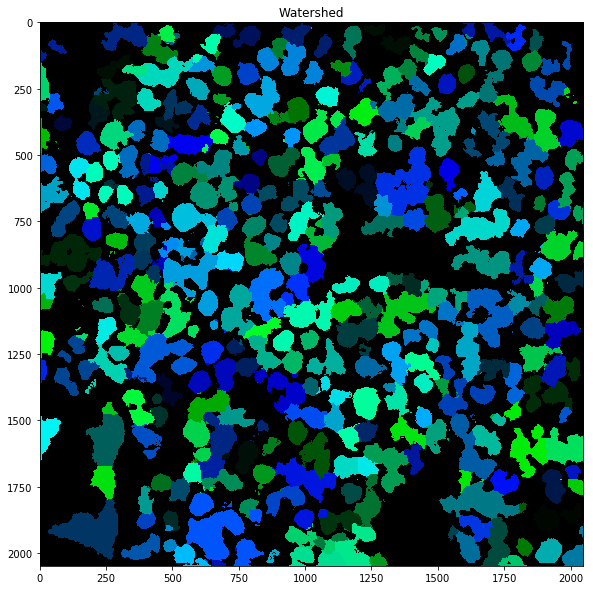

In [44]:
labels = watershed(markers, im_bin, im_edge, d_mat, params['watershed_ratio'], params['remove_image_edges'])
fname = os.path.join(out_path,'watershed_Pos235.tiff')
tifffile.imsave(fname, np.swapaxes(labels,0,2), metadata={'axes': 'ZYX'})
out = colorize_segmented_image(labels[:,:,z], 'bg')
Display(out,title='Watershed')

(0, 2000000)

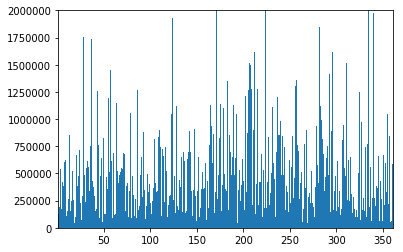

In [54]:
plt.hist(np.log2(labels.ravel()),bins=np.max(labels))
plt.xlim([1,np.max(labels)])
plt.ylim([0,np.log2(2500000)])

In [52]:
from collections import Counter
counts = Counter(labels.ravel()[labels.ravel()>0])

In [60]:
cells = []
not_cells = []

for label,pixels in counts.items():
    if pixels < 500000:
        not_cells.append(label)
    elif pixels > 2000000:
        not_cells.append(label)
    else:
        cells.append(label)

In [61]:
len(cells)

147

In [62]:
len(not_cells)

214

In [63]:
labels_filtered = labels
for i in not_cells:
    labels_filtered[labels_filtered==i]=0

KeyboardInterrupt: 

In [ ]:
out = colorize_segmented_image(labels_filtered[:,:,z], 'bg')
Display(out,title='Watershed')

In [53]:
counts

Counter({1: 127456,
         38: 373229,
         12: 1060133,
         2: 192080,
         4: 176016,
         8: 625789,
         7: 602930,
         17: 256595,
         6: 387196,
         13: 853537,
         27: 760534,
         3: 542058,
         9: 111923,
         5: 420403,
         16: 524270,
         23: 717414,
         15: 246780,
         11: 268724,
         10: 157467,
         22: 476134,
         14: 152693,
         31: 546935,
         36: 1734842,
         35: 749989,
         28: 1753835,
         19: 102086,
         44: 762358,
         18: 39799,
         20: 668794,
         33: 555119,
         21: 381156,
         37: 427451,
         32: 618678,
         29: 484992,
         24: 225365,
         26: 294554,
         54: 1190263,
         30: 235419,
         25: 67292,
         34: 334071,
         43: 1261673,
         39: 289272,
         47: 639940,
         41: 153074,
         40: 153081,
         49: 825769,
         45: 89488,
         46: 477731,

In [56]:
1060133*0.1*0.1*0.4

4240.532000000001